In [1]:
from typing import Any


class Container(object):
    def __init__(self, config=None, **extras):
        """Dictionary wrapper to access keys as attributes.
        Args:
            config (dict or Config): Configurations
            extras (kwargs): Extra configurations
        Examples:
            >>> cfg = Config({'lr': 0.01}, momentum=0.95)
            or
            >>> cfg = Config({'lr': 0.01, 'momentum': 0.95})
            then, use as follows:
            >>> print(cfg.lr, cfg.momentum)
        """
        if config is not None:
            if isinstance(config, dict):
                for k in config:
                    setattr(self, k, config[k])
            elif isinstance(config, self.__class__):
                self.__dict__ = config.__dict__.copy()
            else:
                raise ValueError("Unknown config")

        for k, v in extras.items():
            setattr(self, k, v)

    def get(self, key: str, default: Any) -> Any:
        return getattr(self, key, default)

    def set(self, key: str, value: Any) -> None:
        setattr(self, key, value)

In [2]:
from datasets import init_dataset

args = Container({'mode': 'max', 'batch_size': 1, 'resolution': 420, 'pixelSize': 'min', 'label_name': 'CX', 'image_mode': 'only_lesion', 'gpu_id': '0', 'use_clinical': True})
datasets, dataloaders = init_dataset(args)

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id

In [4]:
test_loader = iter(dataloaders['test'])

while True:
    # sample a batch
    test_img, test_clinical_data, test_target_onehot, test_image_id = next(test_loader)
    if test_target_onehot[:, 1]==1:
        break

In [5]:
import torch

# load pre-trained model
model_path = "/data/Radiomics_model/only_lesion/min/CX/I3ResNet__max__with_clinical__without_radiomics.pt"
#model_path = "/data/Radiomics_model/only_lesion/min/CX/I3ResNet__max__without_clinical__without_radiomics.pt"
device = torch.device("cuda:0")

model = torch.load(model_path)
model.eval()
model.to(device)

I3ResNet(
  (stem): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AdaptiveMaxPool3d(output_size=(39, 56, 56))
  )
  (layer1): Sequential(
    (0): Bottleneck3d(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv3d(64, 256, kernel_si

In [6]:
class Activation():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_function)
    def hook_function(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.close()

In [7]:
first_conv = model.stem[0]

activation = Activation(module=first_conv) # hook interface

In [8]:
_ = model.forward(test_img.to(device), test_clinical_data.to(device))
featuremaps = activation.features

In [9]:
featuremaps.shape

torch.Size([1, 64, 77, 112, 112])

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [11]:
# Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
mean_val=[0.485, 0.456, 0.406]
std_val=[0.229, 0.224, 0.225]

def denormalize_data(data):
    res = data * torch.tensor(std_val).view(-1, 1, 1, 1) + torch.tensor(mean_val).view(-1, 1, 1, 1)
    return res.clamp_(0.0, 1.0)

org_inp = denormalize_data(test_img[0])
print(org_inp.shape)

torch.Size([3, 77, 224, 224])


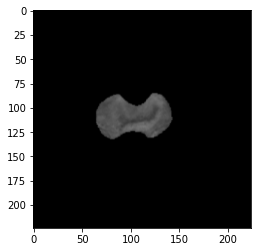

In [12]:
plt.imshow(org_inp[:, 0].permute(1,2,0))

## Conv feature visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


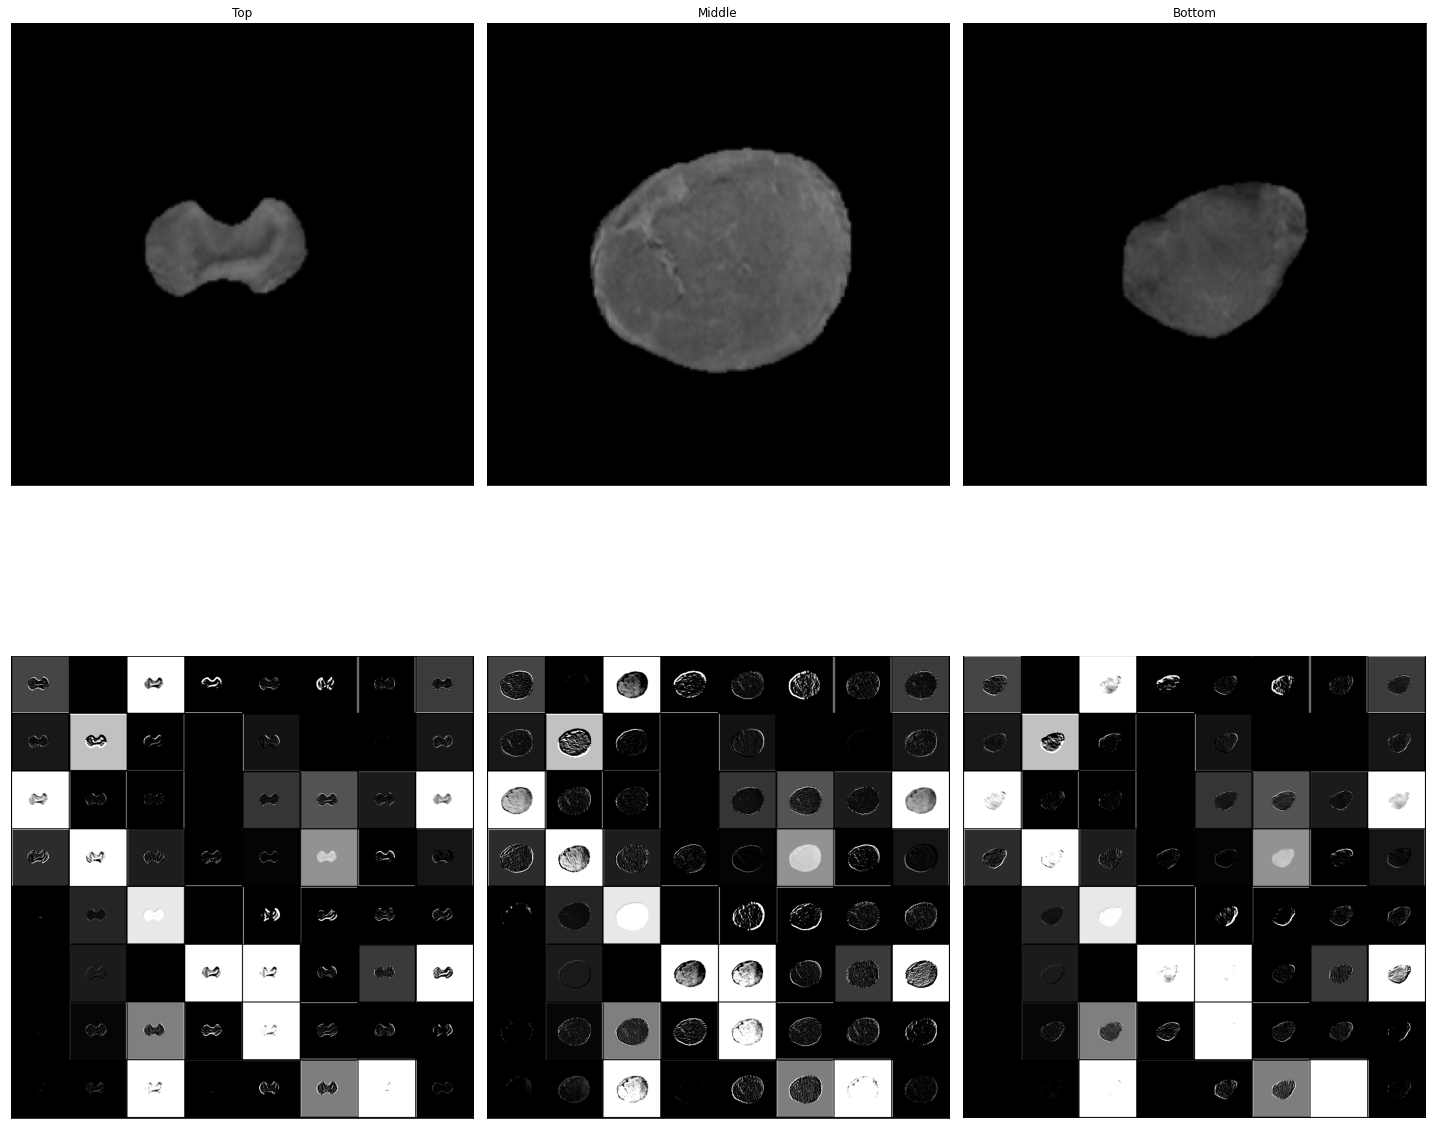

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,20))

ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]

ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]

ax00.imshow(org_inp[:, 0].permute(1,2,0).cpu())
ax00.set_title("Top")
ax00.set_xticks([])
ax00.set_yticks([])


grid_img = make_grid(featuremaps[0,:,None,0])
ax10.imshow(grid_img.permute(1,2,0).cpu())
ax10.set_xticks([])
ax10.set_yticks([])

ax01.imshow(org_inp[:, 28].permute(1,2,0).cpu())
ax01.set_title("Middle")
ax01.set_xticks([])
ax01.set_yticks([])

grid_img = make_grid(featuremaps[0,:,None,28])
ax11.imshow(grid_img.permute(1,2,0).cpu())
ax11.set_xticks([])
ax11.set_yticks([])

ax02.imshow(org_inp[:, 56].permute(1,2,0).cpu())
ax02.set_title("Bottom")
ax02.set_xticks([])
ax02.set_yticks([])

grid_img = make_grid(featuremaps[0,:,None,56])
ax12.imshow(grid_img.permute(1,2,0).cpu())
ax12.set_xticks([])
ax12.set_yticks([])



plt.axis('off'), plt.xticks([]), plt.yticks([])
plt.tight_layout()
#plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.savefig("conv_features.png", 
            bbox_inces='tight', 
            transparent = True,
            pad_inches=0, 
            dpi=300)

## Conv filter visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


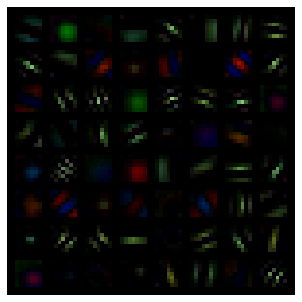

In [14]:
grid_img = make_grid(first_conv.weight[:,:].sum(2))
plt.imshow(grid_img.permute(1,2,0).cpu())
plt.axis('off'), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.savefig("conv_kernels.png", 
            bbox_inces='tight', 
            transparent = True,
            pad_inches=0, 
            dpi=300)